In [3]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import phate
import scprep
import scipy


import sys
import yaml
import phate
import torch
import pytorch_lightning as pl
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import WandbLogger
from sklearn.manifold import MDS


sys.path.append("../")
from src.models.lit_encoder import LitAutoencoder
from src.models.lit_encoder import LitDistEncoder
from src.data.make_dataset import train_dataloader
from src.data.make_dataset import make_n_sphere_two
from src.data.make_dataset import make_tree
from src.data.make_dataset import make_live_seq
from src.data.make_dataset import make_pbmc
from src.data.make_dataset import make_ipsc
from src.fim_noemb import FIM
import os
from sklearn.decomposition import PCA
import math
import random
import pickle

import h5py
import numpy as np
import scipy.io as sio
import pandas as pd

# Tree Data

In [46]:
# Data Parameters
dataset = "tree"
n_obs = 1500
n_dim = 10
batch_size = 20

# Model param
encoder_layer = [150,150,100]
decoder_layer = [2,10,10]
emb_dim = encoder_layer[-1]
activation = "ReLU"
lr = 0.0001
kernel_type = "phate"  # "gaussian" and "phate".
loss_emb = False  # Embedding loss.
loss_dist = True # distance loss in the embedding.
loss_rec = False
bandwitdh = 1  # bandwitdh for the gaussian kernel
t = 20  # time for the gaussian kernel. For PHATE, we use their optimal time.
scale = 0.0005  # scale when we add noise to do the data (before the encoder).
knn = 5 # PHATE kernel number of Nearest Neighbors.
logp=True #Rescale of PHATE parameters

# Trainer param
max_epochs = 100
fast_dev_run = False
accelerator = "gpu"
devices = 1

exp_name = "tree_autoencoder_logp"
seed = torch.randint(0, 1000, size=(1,))

In [47]:
# If you want to save and view in Wandb
wandb = False
logger = WandbLogger(project="tree_autoenocder_logp", name=exp_name) if wandb else False

In [48]:
train_loader = train_dataloader(dataset, n_obs, n_dim, emb_dim, batch_size,knn)


In [49]:
# SEED
pl.utilities.seed.seed_everything(seed=seed)

# data loader for the training set.
# train_loader = train_dataloader(dataset, n_obs, n_dim, emb_dim, batch_size,knn)

# Defining the pytorch lightning model.
model = LitAutoencoder(
    input_dim=n_dim,
    emb_dim=emb_dim,
    encoder_layer=encoder_layer,
    decoder_layer=decoder_layer,
    activation=activation,
    lr=lr,
    kernel_type=kernel_type,
    loss_emb=loss_emb,
    loss_dist=loss_dist,
    loss_rec=loss_rec,
    bandwitdh=bandwitdh,
    t=t,
    scale=scale,
    knn = knn,
    logp=logp
)

# Defining the trainer
# NOTE, we can add more things like gradient clipping, early stopping, Callbacks etc..
# NOTE logger is set to `FALSE`, change to `True` to keep tracks of the metrics.
# NOTE  `enable_checkpointing ` is set to `False`, set to `True` to keep checkpoints of the model.
trainer = Trainer(
    max_epochs=max_epochs,
    fast_dev_run=fast_dev_run,
    accelerator=accelerator,
    devices=devices,
    logger=logger,
    enable_checkpointing=False,
)


# Train the model
trainer.fit(model, train_dataloaders=train_loader)

Global seed set to 413


[Linear(in_features=10, out_features=150, bias=True), ReLU(), Linear(in_features=150, out_features=150, bias=True), ReLU(), Linear(in_features=150, out_features=100, bias=True), Softmax(dim=1)]
[Linear(in_features=100, out_features=2, bias=True), ReLU(), Linear(in_features=2, out_features=10, bias=True), ReLU(), Linear(in_features=10, out_features=10, bias=True), ReLU()]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | encoder | Sequential | 39.4 K
1 | decoder | Sequential | 342   
---------------------------------------
39.7 K    Trainable params
0         Non-trainable params
39.7 K    Total params
0.159     Total estimated model params size (MB)
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:219: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 36 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


In [11]:
#save model (and load model)

torch.save(model.state_dict(),'saved_models/tree_model_1_21_JSD.pt')
#model.load_state_dict(torch.load('saved_models/tree_model_1_18.pt'))


In [50]:
#Evaluate pytorch model on new data and embed with MDS

tree_data, tree_phate, tree_clusters = make_tree(n_obs=1500,dim=10,emb_dim=2,knn=knn)
tree_data = tree_data.to('cuda')
model.cuda()
model.eval()
pred = model.encode(tree_data).detach().cpu().numpy()
mds_operator = MDS()
predemb = mds_operator.fit_transform(pred)

In [20]:
#Evaluate with PCA

pca = PCA(n_components=2)
print(pred.shape)
pca.fit(pred)


(1500, 50)


PCA(n_components=2)

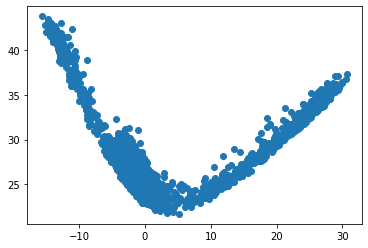

In [9]:

pcapred = pred @ pca.components_.T
plt.figure()
plt.scatter(pcapred[:,0],pcapred[:,1])


torch.Size([1500, 10])
(2, 10)


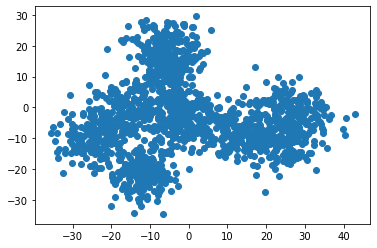

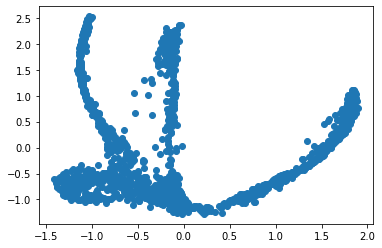

In [8]:
#Evaluate with PCA


tree_data, tree_phate, tree_clusters = make_tree(n_obs=1500,dim=10,emb_dim=2,knn=5)
#tree_data = tree_data.to('cuda')
#model.cuda()
#model.eval()
#pred = model.encode(tree_data).detach().cpu().numpy()

#Ground Truth
pca = PCA(n_components=2)
pca.fit(tree_data.detach().numpy())
print(tree_data.shape)
print(pca.components_.shape)
ntree = tree_data.detach().numpy() @ pca.components_.T

plt.figure()
plt.scatter(ntree[:,0],ntree[:,1])

#Predictions
plt.figure()
plt.scatter(tree_phate[:,0],tree_phate[:,1])



In [9]:
#Test JSD 

tree_data, tree_phate, tree_clusters = make_tree(n_obs=50,dim=10,emb_dim=2,knn=5)
from torch.functional import F


def computeJSDist(X):
    " Outputs N x N distance matrix for N observations"
    " NOTE: function assumes input X has been log transformed"
    
    jsdtens = []
    for i in range(X.size()[0]):

        p = X[i,:]
        m = 0.5 * (p + X)

        klone = (p.exp()*(p - m)).sum(dim=1)
        kltwo = (X.exp()*(X - m)).sum(dim=1)
        jsdtens.append((0.5*klone) + (0.5*kltwo))

    jdist = torch.stack(jsdtens,dim=0)

    return jdist

JSD_dist = computeJSDist(tree_data)
print(JSD_dist.size())
#JSD function




torch.Size([300, 300])


In [48]:


def computeJSD(X):

    jsd = torch.zeros((X.shape[0],X.shape[0]))
    for i in range(X.shape[0]):
        for j in range(X.shape[0]):

            p = tree_data[i,:]
            q = tree_data[j,:]
            m = 0.5 * (p + q)
            
            kone = 0.5 *((p.exp() * (p - m)).sum())
            ktwo = 0.5 *((q.exp() * (q - m)).sum())
            k = kone + ktwo                        
            jsd[i,j] = k
            
  
    return jsd



In [ ]:

temp = computeJSD(tree_data)

print(temp)
print(temp.shape)





In [ ]:
print(temp[50,:])

In [51]:

jsd = torch.zeros((tree_data.shape[0],tree_data.shape[0]))
for i in range(tree_data.shape[0]):
    
    p = tree_data[i,:]
    q = tree_data
    m = 0.5 * (p + q)
  
    kone = 0.5 *((p.exp() * (p - m)).sum(dim=1))
    ktwo = 0.5 *((q.exp() * (q - m)).sum(dim=1))
    k = kone + ktwo
 
    jsd[i,:] = k
  



In [ ]:
print(jsd[50,:])

In [24]:
from scipy.spatial import distance

tempone = tree_data[0,:].detach().numpy()
temptwo = tree_data[1,:].detach().numpy()

pone = tempone/tempone.sum(axis=0)
ptwo = temptwo/temptwo.sum(axis=0)

print(pone)
print(ptwo)
a = np.array([[1,2,3],[2,3,1]])
b = np.array([[5,62,3],[6,2,1]])
print(a.shape)
distance.jensenshannon(pone.T,ptwo.T)


[ 0.09240666  0.14312263 -0.03033439 -0.18335727 -0.33118144  0.22296478
  0.39681974  0.83399844  0.20404306 -0.3484823 ]
[-0.19055088 -0.35211286 -0.26622152  0.98737234 -0.019126    0.22479251
  1.0427166  -0.05514266  0.4844244  -0.856152  ]
(2, 3)


inf

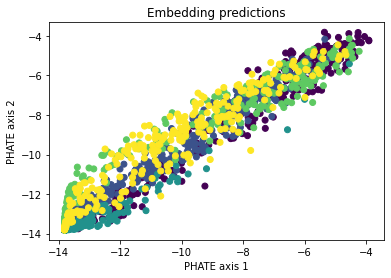

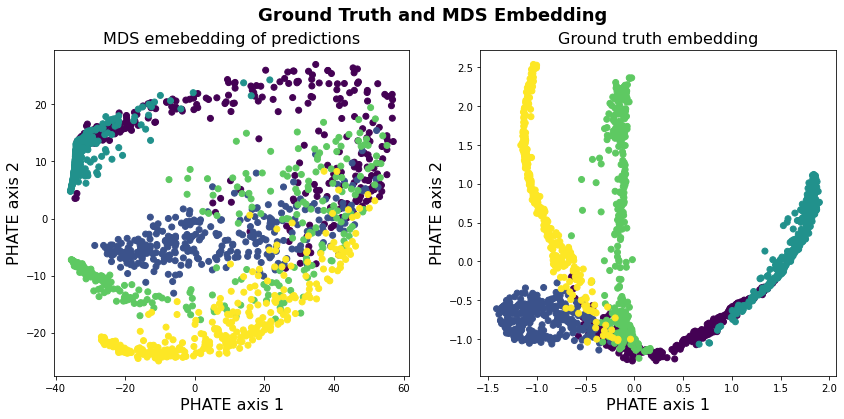

In [51]:
#Plotting

plt.figure()
plt.title("Embedding predictions")
plt.scatter(pred[:, 0], pred[:, 1], c= tree_clusters)
plt.xlabel("PHATE axis 1")
plt.ylabel("PHATE axis 2")

plt.figure(figsize = (14,6))
plt.suptitle("Ground Truth and MDS Embedding",fontweight='bold',fontsize=18)
plt.subplot(121)
plt.title("MDS emebedding of predictions",fontsize=16)
plt.scatter(predemb[:, 0], predemb[:, 1], c= tree_clusters)
plt.xlabel("PHATE axis 1",fontsize=16)
plt.ylabel("PHATE axis 2",fontsize=16)


plt.subplot(122)
plt.title("Ground truth embedding",fontsize=16)
plt.scatter(tree_phate[:,0],tree_phate[:,1], c=tree_clusters )
plt.xlabel("PHATE axis 1",fontsize=16)
plt.ylabel("PHATE axis 2",fontsize=16)


np.save("saved_data/5_300_tree_1_21_1500_pred_JSD.npy",pred)
np.save("saved_data/5_300_tree_1_21_1500_pred_MDS_JSD.npy",predemb)
np.save("saved_data/5_300_tree_1_21_1500_ground_truth_JSD.npy",tree_phate)
plt.savefig("Figures/5_300_tree_1_21_1500_ground_truth_JSD.png")


In [9]:
#Compute FIM 
n_obs = tree_data.shape[0]
model.cuda()
fcn = model.encode
fisher = FIM(tree_data,fcn,n_obs,n_dim,emb_dim,pred)
fishermat, J = fisher.fit()
e,v = fisher.get_eigs()

#quad = fisher.get_quadform(e[0,:])
#eone = np.zeros((v.shape[2])) #dimensionality of eigenvectors
#eone[0] = 1
#quad = fisher.get_quadform(eone)
volume = fisher.get_volume()

#Projecting eigenvectors to two dimensions for visualization
tvec = torch.unsqueeze(torch.tensor(v[:,:,0]).float().cuda(),0)
model.eval()
vout = model.encode(tvec).squeeze()
neivec = mds_operator.fit_transform(vout.detach().cpu().numpy())


In [21]:
pcaeivec = vout.squeeze().detach().cpu().numpy()

In [22]:
print(pcaeivec.shape)

(1500, 50)


(1500, 2)
(50, 2)
(1500, 2)


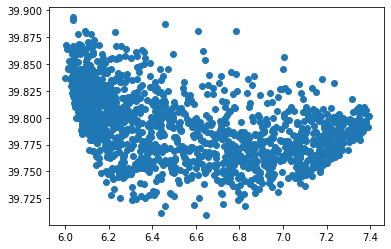

In [23]:
print(neivec.shape)
print(pca.components_.T.shape)
x = pcaeivec @ pca.components_.T
print(x.shape)

plt.scatter(x[:,0],x[:,1])

In [10]:
#Debugging/Nonsense Code
np.random.randint(0,360,1)[0]
print(e[0:5,:])
print(J.shape)
print(e.shape)
rint = np.random.randint(0,e.shape[0],size=10)
print(rint[0])
print(tree_phate.shape)
print(predemb.shape)
print(pred.shape)

"""
#Getting low dimensional eigenvectors
ldimeivec = np.zeros((J.shape[0],J.shape[1]))
for i in range(J.shape[0]):
    vtest = v[i,-1,:] #Get top eigenvector for each sample
    Jtest = J[i,:,:] #Get Jacobian for each sample
    ldimeivec[i,:] = np.expand_dims(Jtest @ vtest,axis=0) #Project down to 2 dimensions
    
print(predemb.shape)
print(ldimeivec.shape)
print(v.shape)
print(v[tind,0,:].shape)
print(predemb[tind,1].shape)

"""

"""
plt.figure()
plt.scatter(predemb[tind,0],predemb[tind,1],c=tind)
plt.quiver(predemb[tind,0],predemb[tind,1],u,vee)
plt.quiver(predemb[tind,0],predemb[tind,1],ut,veet)


        
plt.figure()
#plt.scatter(ldimeivec[:,0],ldimeivec[:,1],marker = ",") #plotting eigenvec [nsamp x dims]
plt.scatter(predemb[tind,0], predemb[tind,1], c= ntrace)
plt.colorbar()
sys.exit()

"""

#plt.subplot(231)
#plt.title("Volume",fontsize=14)
#plt.plot(nvolume)
#plt.xlabel("Data points",fontsize=14)
#plt.ylabel("Normalized volume",fontsize=14)

[[0.0098134  0.00382471 0.00240291 0.00189112 0.00098521 0.00020661
  0.00073298 0.00060296 0.00049979 0.00045258]
 [0.01192276 0.00258915 0.00196463 0.00172241 0.00111712 0.00020554
  0.00035915 0.00049477 0.00064988 0.0009544 ]
 [0.00716486 0.00455612 0.00213124 0.00164425 0.00122007 0.00019486
  0.00035848 0.00100241 0.00059248 0.00066148]
 [0.01050808 0.00449396 0.00243287 0.00145241 0.00109164 0.00095467
  0.00079686 0.00026341 0.00031432 0.00046295]
 [0.00978533 0.00291096 0.00192899 0.0017469  0.00114277 0.00089293
  0.00026672 0.00068958 0.00060362 0.00041497]]
(1500, 50, 10)
(1500, 10)
435
(1500, 2)
(1500, 2)
(1500, 50)


'\nplt.figure()\nplt.scatter(predemb[tind,0],predemb[tind,1],c=tind)\nplt.quiver(predemb[tind,0],predemb[tind,1],u,vee)\nplt.quiver(predemb[tind,0],predemb[tind,1],ut,veet)\n\n\n        \nplt.figure()\n#plt.scatter(ldimeivec[:,0],ldimeivec[:,1],marker = ",") #plotting eigenvec [nsamp x dims]\nplt.scatter(predemb[tind,0], predemb[tind,1], c= ntrace)\nplt.colorbar()\nsys.exit()\n\n'

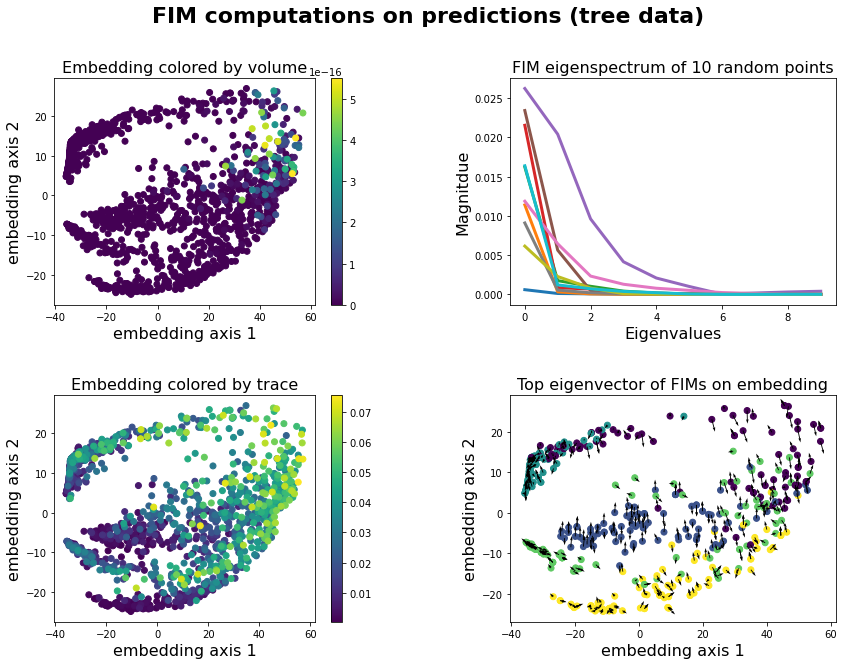

In [52]:
#Function for discarding outliers
per = 0.95 #CI to keep
def discard_out(metric,n_obs,per):
    
    ns_obs = per*n_obs
    out = int((n_obs - ns_obs)/2)
    sor = np.argsort(metric)
    lwindx = out
    upindx = n_obs - out
    sortind = sor[lwindx:upindx]
    return sortind


#Get Volume
#volume = volume/np.max(volume) #normalization
vind = discard_out(volume,n_obs,per)
nvolume = volume[vind]#/np.max(volume[vind])


#Compute quadratic form of first eigenvector
#quad = quad/np.max(quad)
#qind = discard_out(quad,n_obs,per)
#nquad = quad[qind]/np.max(quad[qind])


#Get Max eigenvalue
#emax = e[:,0]/np.max(trace) #normalized trace
#eind = discard_out(emax,n_obs,per)
#ne = emax[eind]/np.max(emax[eind])


#Get Trace
trace = np.zeros((n_obs))
for i in range(n_obs):
    trace[i] = np.sum(e[i,:])

#trace = trace/np.max(trace) #normalized trace
tind = discard_out(trace,n_obs,per)
ntrace = trace[tind]#/np.max(trace[tind])


plt.figure(figsize=(14,10))
plt.suptitle("FIM computations on predictions (tree data) ",fontsize=22,fontweight='bold')
plt.subplots_adjust(hspace=0.4,wspace=0.4)

#Trace
#plt.subplot(221)
#plt.title("Trace of FIM",fontsize=16)
#plt.plot(nvolume,linewidth=3)
#plt.xlabel("Data points",fontsize=16)
#plt.ylabel("Magnitude",fontsize=16)

#Volume
plt.subplot(221)
plt.title("Embedding colored by volume",fontsize=16)
plt.scatter(predemb[vind, 0], predemb[vind, 1], c= nvolume)
plt.xlabel("embedding axis 1",fontsize=16)
plt.ylabel("embedding axis 2",fontsize=16)
plt.colorbar()


#Eigenspectrum
rint = np.random.randint(0,n_obs,size=10)
plt.subplot(222)
plt.title("FIM eigenspectrum of 10 random points",fontsize=16)
for i in rint:
    plt.plot(e[i,:],linewidth=3)
    #plt.plot(e[eind[i],:]/np.max(e[eind[i],:]))
plt.xlabel("Eigenvalues",fontsize=16)
plt.ylabel("Magnitdue",fontsize=16)


#Trace
#plt.subplot(223)
#plt.title("Encoded embedding colored by trace of FIM",fontsize=16)
#plt.scatter(predemb[tind, 0], predemb[tind, 1], c= ntrace)
#plt.xlabel("PHATE axis 1",fontsize=16)
#plt.ylabel("PHATE axis 2",fontsize=16)
#plt.colorbar()



#Trace
plt.subplot(223)
plt.title("Embedding colored by trace",fontsize=16)
plt.scatter(predemb[tind, 0], predemb[tind, 1], c= ntrace)
plt.xlabel("embedding axis 1",fontsize=16)
plt.ylabel("embedding axis 2",fontsize=16)
plt.colorbar()



#Visualization of eignevectors
reint = np.random.randint(0,tree_phate.shape[0],size=500) #Random 
plt.subplot(224)
plt.title("Top eigenvector of FIMs on embedding",fontsize=16)
plt.scatter(predemb[reint,0],predemb[reint,1],c=tree_clusters[reint])
plt.quiver(predemb[reint,0],predemb[reint,1],neivec[reint,0],neivec[reint,1],color = 'black',scale=20)
plt.xlabel("embedding axis 1",fontsize=16)
plt.ylabel("embedding axis 2",fontsize=16)

plt.savefig("Figures/5_300_tree_FIMcomps_1_21_JSD.png")

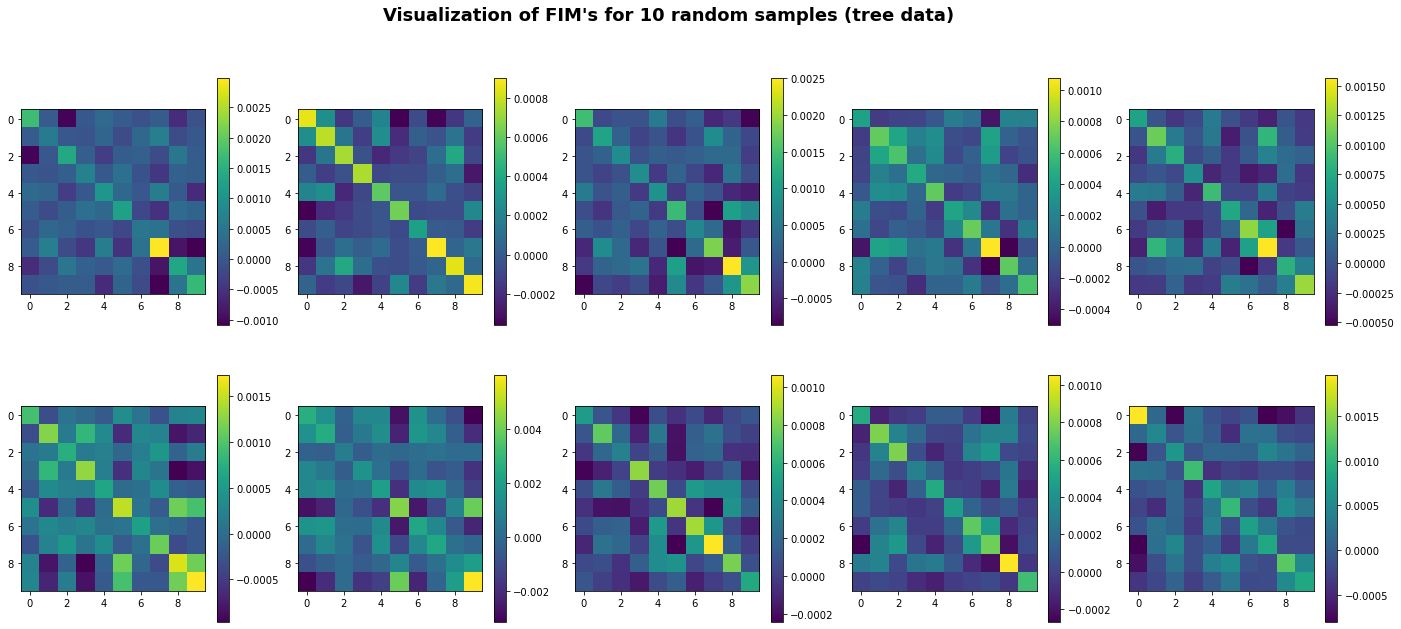

In [12]:
plt.figure(figsize = (24,10))
plt.suptitle("Visualization of FIM's for 10 random samples (tree data)",fontsize=18,fontweight='bold')
for i in range(len(rint)):
    plt.subplot(2,5,i+1)
    plt.imshow(fishermat[rint[i],:,:])
    plt.colorbar()
    
plt.savefig('random_FIMs.png')

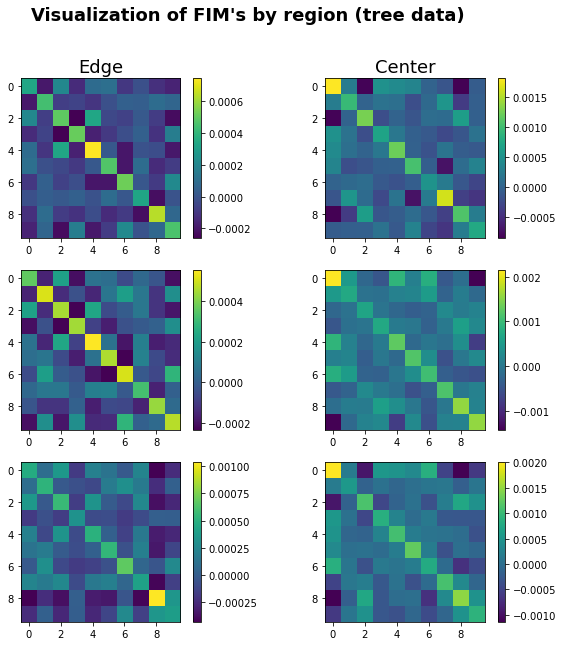

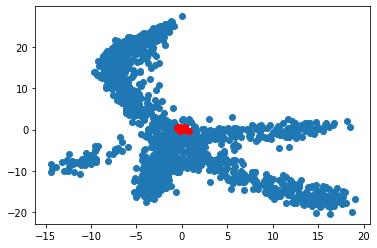

In [11]:
#Compute and sort embedding distances
distind = np.argsort(np.linalg.norm((predemb - predemb.mean(0)),axis=1))
plt.figure(figsize = (10,10))
plt.suptitle("Visualization of FIM's by region (tree data)",fontsize=18,fontweight='bold')

a = int(len(distind)) -1 #specifies index in sorted vector to get edges

for i in range(6):
    plt.subplot(3,2,i+1)
    
    if i == 1 or i == 3 or i == 5: #(for plotting)
        if i == 1:
            plt.title("Center",fontsize=18)
        plt.imshow(fishermat[distind[i],:,:])
        plt.colorbar()
        
    else:
        if i == 0: #(for plotting)
            plt.title("Edge",fontsize=18)
        plt.imshow(fishermat[distind[a],:,:])
        plt.colorbar()
        
    a = a - 1
    
plt.savefig("Figures/5_300_tree_regional_FIMs_1_17.png")

plt.figure()
plt.scatter(predemb[:,0],predemb[:,1])
plt.scatter(predemb[distind[:10],0],predemb[distind[:10],1],c='red')

# Sphere Data

In [53]:
# Data Parameters
dataset = "sphere"
n_obs = 1500
n_dim = 10
batch_size = 100

# Model param
encoder_layer = [100,100,50]
decoder_layer = [2,10,10]
emb_dim = encoder_layer[-1]
activation = "ReLU"
lr = 0.0001
kernel_type = "phate"  # "gaussian" and "phate".
loss_emb = False  # Embedding loss.
loss_dist = True # distance loss in the embedding.
loss_rec = False
bandwitdh = 1  # bandwitdh for the gaussian kernel
t = 1  # time for the gaussian kernel. For PHATE, we use their optimal time.
scale = 0.0005  # scale when we add noise to do the data (before the encoder).
knn = 10 # PHATE kernel number of Nearest Neighbors.
logp=True

# Trainer param
max_epochs = 100
fast_dev_run = False
accelerator = "gpu"
devices = 1

exp_name = "sphere_autoencoder_logp"
seed = torch.randint(0, 1000, size=(1,))

In [54]:
# If you want to save and view in Wandb
wandb = False
logger = WandbLogger(project="sphere_autoenocder_logp", name=exp_name) if wandb else False

In [55]:
train_loader = train_dataloader(dataset, n_obs, n_dim, emb_dim, batch_size,knn)

In [56]:
# SEED
pl.utilities.seed.seed_everything(seed=seed)

# data loader for the training set.
#train_loader = train_dataloader(dataset, n_obs, n_dim, emb_dim, batch_size,knn)

# Defining the pytorch lightning model.
model_sphere = LitAutoencoder(
    input_dim=n_dim,
    emb_dim=emb_dim,
    encoder_layer=encoder_layer,
    decoder_layer=decoder_layer,
    activation=activation,
    lr=lr,
    kernel_type=kernel_type,
    loss_emb=loss_emb,
    loss_dist=loss_dist,
    loss_rec=loss_rec,
    bandwitdh=bandwitdh,
    t=t,
    scale=scale,
    knn = knn,
    logp=logp
)

# Defining the trainer
# NOTE, we can add more things like gradient clipping, early stopping, Callbacks etc..
# NOTE logger is set to `FALSE`, change to `True` to keep tracks of the metrics.
# NOTE  `enable_checkpointing ` is set to `False`, set to `True` to keep checkpoints of the model.
trainer = Trainer(
    max_epochs=max_epochs,
    fast_dev_run=fast_dev_run,
    accelerator=accelerator,
    devices=devices,
    logger=logger,
    enable_checkpointing=False,
)


# Train the model
trainer.fit(model_sphere, train_dataloaders=train_loader)

Global seed set to 851


[Linear(in_features=10, out_features=100, bias=True), ReLU(), Linear(in_features=100, out_features=100, bias=True), ReLU(), Linear(in_features=100, out_features=50, bias=True), Softmax(dim=1)]
[Linear(in_features=50, out_features=2, bias=True), ReLU(), Linear(in_features=2, out_features=10, bias=True), ReLU(), Linear(in_features=10, out_features=10, bias=True), ReLU()]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | encoder | Sequential | 16.2 K
1 | decoder | Sequential | 242   
---------------------------------------
16.5 K    Trainable params
0         Non-trainable params
16.5 K    Total params
0.066     Total estimated model params size (MB)
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:219: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 36 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=300` reached.


In [79]:
#save model (and load model)

torch.save(model_sphere.state_dict(),'saved_models/sphere_model_1_21.pt')
#model.load_state_dict(torch.load('saved_models/sphere_model_1_18.pt'))

In [60]:
#Evaluate pytorch model on new data

sphere_data, sphere_phate = make_n_sphere_two(n_obs=n_obs,dim=10,emb_dim=2,knn=knn)
sphere_data = sphere_data.to('cuda')
model_sphere.cuda()
model_sphere.eval()
pred = model_sphere.encode(sphere_data).detach().cpu().numpy()

mds_operator = MDS()
predemb = mds_operator.fit_transform(pred)


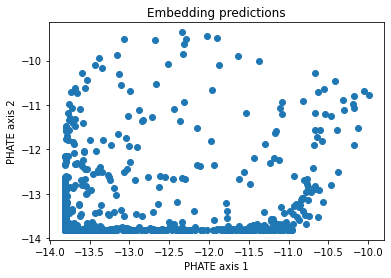

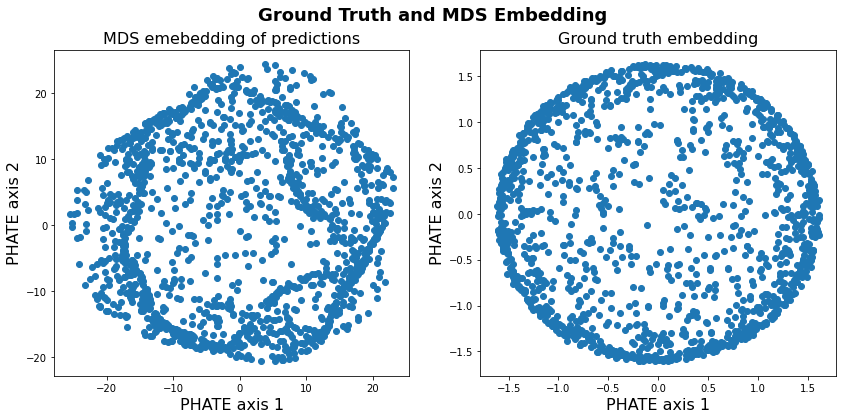

In [61]:


plt.figure()
plt.title("Embedding predictions")
plt.scatter(pred[:, 0], pred[:, 1])
plt.xlabel("PHATE axis 1")
plt.ylabel("PHATE axis 2")

plt.figure(figsize = (14,6))
plt.suptitle("Ground Truth and MDS Embedding",fontweight='bold',fontsize=18)
plt.subplot(121)
plt.title("MDS emebedding of predictions",fontsize=16)
plt.scatter(predemb[:, 0], predemb[:, 1])
plt.xlabel("PHATE axis 1",fontsize=16)
plt.ylabel("PHATE axis 2",fontsize=16)

plt.subplot(122)
plt.title("Ground truth embedding",fontsize=16)
plt.scatter(sphere_phate[:,0],sphere_phate[:,1])
plt.xlabel("PHATE axis 1",fontsize=16)
plt.ylabel("PHATE axis 2",fontsize=16)


np.save("saved_data/1500_sphere_1_21_1500_pred.npy",pred)
np.save("saved_data/1500_sphere_1_21_1500_pred_MDS.npy",predemb)
np.save("saved_data/1500_sphere_1_21_1500_ground_truth.npy",tree_phate)
plt.savefig("Figures/1500_sphere_1_21_1500_ground_truth.png")

In [65]:
print(sphere_data.shape)

torch.Size([1500, 10])


In [73]:

#Compute FIM 
n_obs = sphere_data.shape[0]
model_sphere.cuda()
fcn = model_sphere.encode
fisher = FIM(sphere_data,fcn,n_obs,n_dim,emb_dim,pred)
fishermat, J = fisher.fit()
e,v = fisher.get_eigs()

#quad = fisher.get_quadform(e[0,:])
#eone = np.zeros((v.shape[2])) #dimensionality of eigenvectors
#eone[0] = 1
#quad = fisher.get_quadform(eone)
volume = fisher.get_volume()

#Projecting eigenvectors to two dimensions for visualization
tvec = torch.unsqueeze(torch.tensor(v[:,:,0]).float().cuda(),0)
model_sphere.eval()
vout = model_sphere.encode(tvec).squeeze()
neivec = mds_operator.fit_transform(vout.detach().cpu().numpy())




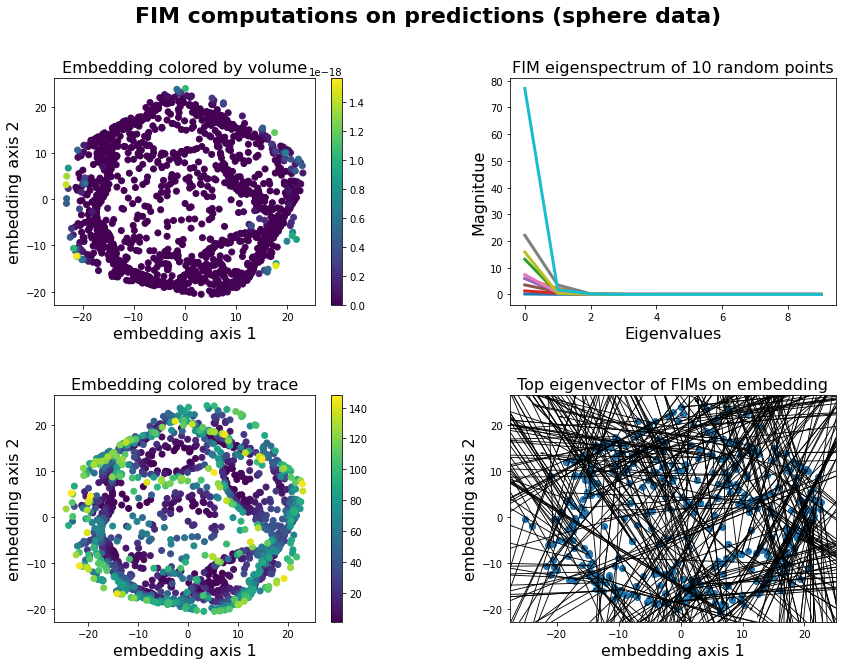

In [74]:
#Function for discarding outliers
per = 0.95 #CI to keep
def discard_out(metric,n_obs,per):
    
    ns_obs = per*n_obs
    out = int((n_obs - ns_obs)/2)
    sor = np.argsort(metric)
    lwindx = out
    upindx = n_obs - out
    sortind = sor[lwindx:upindx]
    return sortind


#Get Volume
#volume = volume/np.max(volume) #normalization
vind = discard_out(volume,n_obs,per)
nvolume = volume[vind]#/np.max(volume[vind])


#Compute quadratic form of first eigenvector
#quad = quad/np.max(quad)
#qind = discard_out(quad,n_obs,per)
#nquad = quad[qind]/np.max(quad[qind])


#Get Max eigenvalue
#emax = e[:,0]/np.max(trace) #normalized trace
#eind = discard_out(emax,n_obs,per)
#ne = emax[eind]/np.max(emax[eind])


#Get Trace
trace = np.zeros((n_obs))
for i in range(n_obs):
    trace[i] = np.sum(e[i,:])

#trace = trace/np.max(trace) #normalized trace
tind = discard_out(trace,n_obs,per)
ntrace = trace[tind]#/np.max(trace[tind])


plt.figure(figsize=(14,10))
plt.suptitle("FIM computations on predictions (sphere data) ",fontsize=22,fontweight='bold')
plt.subplots_adjust(hspace=0.4,wspace=0.4)

#Trace
#plt.subplot(221)
#plt.title("Trace of FIM",fontsize=16)
#plt.plot(nvolume,linewidth=3)
#plt.xlabel("Data points",fontsize=16)
#plt.ylabel("Magnitude",fontsize=16)

#Volume
plt.subplot(221)
plt.title("Embedding colored by volume",fontsize=16)
plt.scatter(predemb[vind, 0], predemb[vind, 1], c= nvolume)
plt.xlabel("embedding axis 1",fontsize=16)
plt.ylabel("embedding axis 2",fontsize=16)
plt.colorbar()


#Eigenspectrum
rint = np.random.randint(0,n_obs,size=10)
plt.subplot(222)
plt.title("FIM eigenspectrum of 10 random points",fontsize=16)
for i in rint:
    plt.plot(e[i,:],linewidth=3)
    #plt.plot(e[eind[i],:]/np.max(e[eind[i],:]))
plt.xlabel("Eigenvalues",fontsize=16)
plt.ylabel("Magnitdue",fontsize=16)



#Trace
plt.subplot(223)
plt.title("Embedding colored by trace",fontsize=16)
plt.scatter(predemb[tind, 0], predemb[tind, 1], c= ntrace)
plt.xlabel("embedding axis 1",fontsize=16)
plt.ylabel("embedding axis 2",fontsize=16)
plt.colorbar()



#Visualization of eignevectors
reint = np.random.randint(0,sphere_phate.shape[0],size=500)  
plt.subplot(224)
plt.title("Top eigenvector of FIMs on embedding",fontsize=16)
plt.scatter(predemb[reint,0],predemb[reint,1])
plt.quiver(predemb[reint,0],predemb[reint,1],neivec[reint,0],neivec[reint,1],color = 'black',scale=15)
plt.xlabel("embedding axis 1",fontsize=16)
plt.ylabel("embedding axis 2",fontsize=16)
plt.savefig("Figures/1500_sphere_FIMcomps_1_18.png")

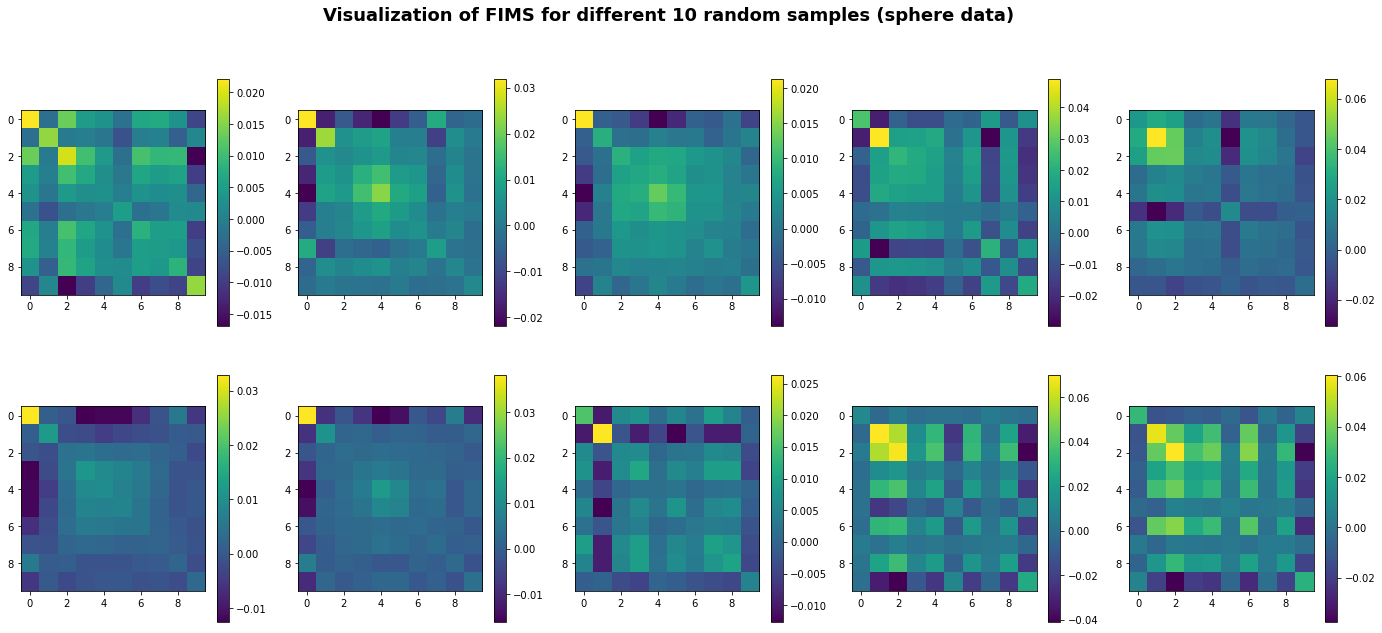

In [104]:
plt.figure(figsize = (24,10))
plt.suptitle("Visualization of FIMS for different 10 random samples (sphere data)",fontsize=18,fontweight='bold')
for i in range(len(rint)):
    plt.subplot(2,5,i+1)
    plt.imshow(fishermat[rint[i],:,:])
    plt.colorbar()

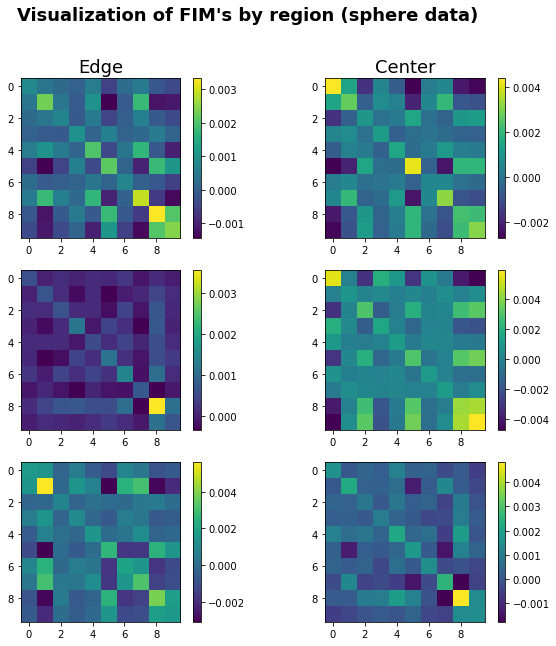

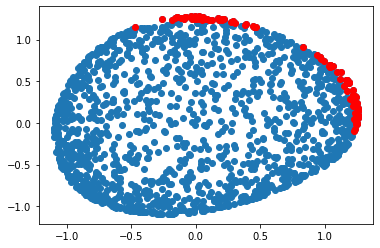

In [23]:

#Compute and sort embedding distances
distind = np.argsort(np.linalg.norm((predemb - predemb.mean(0)),axis=1))
plt.figure(figsize = (10,10))
plt.suptitle("Visualization of FIM's by region (sphere data)",fontsize=18,fontweight='bold')

a = int(len(distind)) -1 #specifies index in sorted vector to get edges

for i in range(6):
    plt.subplot(3,2,i+1)
    
    if i == 1 or i == 3 or i == 5: #(for plotting)
        if i == 1:
            plt.title("Center",fontsize=18)
        plt.imshow(fishermat[distind[i],:,:])
        plt.colorbar()
        
    else:
        if i == 0: #(for plotting)
            plt.title("Edge",fontsize=18)
        plt.imshow(fishermat[distind[a],:,:])
        plt.colorbar()
        
    a = a - 1
    
plt.savefig("Figures/1500_sphere_regional_FIMs_1_17.png")

plt.figure()
plt.scatter(predemb[:,0],predemb[:,1])
plt.scatter(predemb[distind[1400:],0],predemb[distind[1400:],1],c='red')

# PBMC Data

In [75]:
#extract PMBC data size/dimensions

initdir = os.getcwd()
os.chdir(os.path.abspath('..') + '/src/data')
with open('pbmc.pickle','rb') as f:
    X = pickle.load(f).values.squeeze()
os.chdir(initdir)


trainobs = 1500
traind = random.sample(range(0,X.shape[0]),trainobs)
iX = X[traind,:]

print(iX.shape)
print(X.shape)

(1500, 1838)
(2638, 1838)


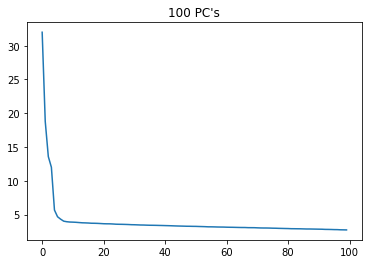

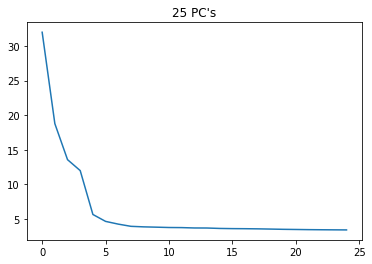

In [76]:
#Apply PCA TO Reduce the dimensions
n_dim = 25
#100 PCs
pca = PCA(n_components=100)
pca.fit(iX)
trainX = iX @ pca.components_.T

plt.figure()
plt.title("100 PC's")
plt.plot(pca.explained_variance_)


#25 PCs
pca = PCA(n_components=25)
pca.fit(iX)
trainX = iX @ pca.components_.T

plt.figure()
plt.title("25 PC's")
plt.plot(pca.explained_variance_)

In [86]:
print(trainX.shape)

(1500, 25)


In [77]:
pbmc_data, pbmc_emb = make_pbmc(n_obs=trainX.shape[0],emb_dim=2,knn=10,indx=traind)

Text(0, 0.5, 'PHATE axis 2')

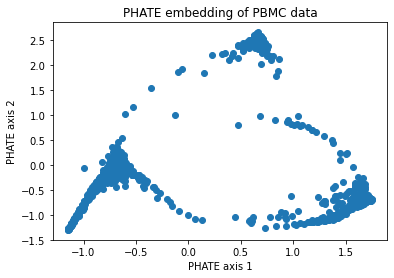

In [78]:
plt.figure()
plt.title("PHATE embedding of PBMC data")
plt.scatter(pbmc_emb[:,0],pbmc_emb[:,1])
plt.xlabel("PHATE axis 1")
plt.ylabel("PHATE axis 2")

In [79]:
# Data Parameters
dataset = "pbmc"
n_obs = trainX.shape[0]
n_dim = n_dim
batch_size = 150

# Model param
encoder_layer = [100,100,50]
decoder_layer = [2,10,10]
emb_dim = encoder_layer[-1]
activation = "ReLU"
lr = 0.0001
kernel_type = "pbmc_phate"  # "gaussian" and "phate".
loss_emb = False  # Embedding loss.
loss_dist = True # distance loss in the embedding.
loss_rec = False
bandwitdh = 1  # bandwitdh for the gaussian kernel
t = 1  # time for the gaussian kernel. For PHATE, we use their optimal time.
scale = 0.0005  # scale when we add noise to do the data (before the encoder).
knn = 5 # PHATE kernel number of Nearest Neighbors.
logp=True

# Trainer param
max_epochs = 300
fast_dev_run = False
accelerator = "gpu"
devices = 1

exp_name = "pbmc_autoencoder_logp"
seed = torch.randint(0, 1000, size=(1,))

In [80]:
print(len(traind))
print(n_dim)
print(X[traind,:])

1500
25
[[-0.263424    3.2503295  -0.05080909 ... -0.10598141 -0.17809859
  -0.50615925]
 [-0.2188678  -0.29233807 -0.04972261 ... -0.12664916  5.0305514
   1.4617422 ]
 [-0.25447893 -0.24697474 -0.04845366 ... -0.05317502 -0.14369254
   2.0619998 ]
 ...
 [-0.36517772 -0.2504998  -0.05402673 ... -0.07840678 -0.11784137
   1.9113094 ]
 [-0.19983234 -0.2812385  -0.04807331 ... -0.10389706 -0.20187023
   1.5938944 ]
 [-0.33757943 -0.28405666 -0.05490484 ... -0.13254213 -0.16772433
  -0.49548134]]


In [81]:
# If you want to save and view in Wandb
wandb = False
logger = WandbLogger(project="pbmc_autoenocder_logp", name=exp_name) if wandb else False

In [82]:
PATH = os.getcwd()
train_loader = train_dataloader(dataset, n_obs, n_dim, emb_dim, batch_size,knn,PATH,indx=traind)

In [83]:
# SEED
pl.utilities.seed.seed_everything(seed=seed)

# data loader for the training set.
#train_loader = train_dataloader(dataset, n_obs, n_dim, emb_dim, batch_size,knn,PATH)

# Defining the pytorch lightning model.
model_pbmc = LitAutoencoder(
    input_dim=n_dim,
    emb_dim=emb_dim,
    encoder_layer=encoder_layer,
    decoder_layer=decoder_layer,
    activation=activation,
    lr=lr,
    kernel_type=kernel_type,
    loss_emb=loss_emb,
    loss_dist=loss_dist,
    loss_rec=loss_rec,
    bandwitdh=bandwitdh,
    t=t,
    scale=scale,
    knn = knn,
    logp=logp
)

# Defining the trainer
# NOTE, we can add more things like gradient clipping, early stopping, Callbacks etc..
# NOTE logger is set to `FALSE`, change to `True` to keep tracks of the metrics.
# NOTE  `enable_checkpointing ` is set to `False`, set to `True` to keep checkpoints of the model.
trainer = Trainer(
    max_epochs=max_epochs,
    fast_dev_run=fast_dev_run,
    accelerator=accelerator,
    devices=devices,
    logger=logger,
    enable_checkpointing=False,
)


# Train the model
trainer.fit(model_pbmc, train_dataloaders=train_loader)

Global seed set to 933


[Linear(in_features=25, out_features=100, bias=True), ReLU(), Linear(in_features=100, out_features=100, bias=True), ReLU(), Linear(in_features=100, out_features=50, bias=True), Softmax(dim=1)]
[Linear(in_features=50, out_features=2, bias=True), ReLU(), Linear(in_features=2, out_features=10, bias=True), ReLU(), Linear(in_features=10, out_features=10, bias=True), ReLU()]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | encoder | Sequential | 17.8 K
1 | decoder | Sequential | 242   
---------------------------------------
18.0 K    Trainable params
0         Non-trainable params
18.0 K    Total params
0.072     Total estimated model params size (MB)
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:219: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 36 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=300` reached.


In [84]:
#save model (and load model)

torch.save(model_pbmc.state_dict(),'saved_models/pbmc_model_1_21.pt')
#model.load_state_dict(torch.load('saved_models/pbmc_model_1_18.pt'))

In [85]:

#model_pbmc = LitAutoencoder(input_dim=n_dim,emb_dim=emb_dim)
#model_pbmc.load_state_dict(torch.load('/home/of56/FIM_farnam/notebooks/saved_models/pbmc_model_1_17_retry.pt'))

testind = list( set(list(np.arange(X.shape[0]))) - set(traind))
pbmc_data, pbmc_phate = make_pbmc(n_obs=len(testind),emb_dim=2,knn=5,indx=testind)

pbmc_data = pbmc_data.to('cuda')
model_pbmc.cuda()
model_pbmc.eval()
pred = model_pbmc.encode(pbmc_data).detach().cpu().numpy()

mds_operator = MDS()
predemb = mds_operator.fit_transform(pred)
print(predemb.shape)

(1138, 2)


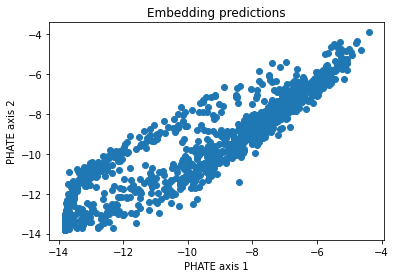

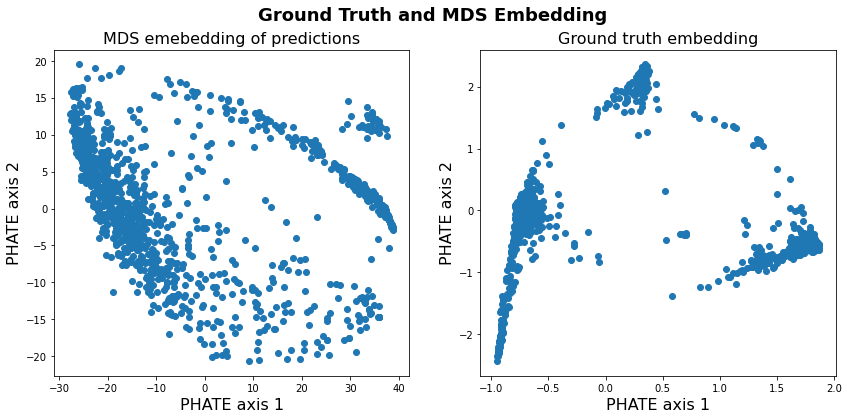

In [87]:

plt.figure()
plt.title("Embedding predictions")
plt.scatter(pred[:, 0], pred[:, 1])
plt.xlabel("PHATE axis 1")
plt.ylabel("PHATE axis 2")

plt.figure(figsize = (14,6))
plt.suptitle("Ground Truth and MDS Embedding",fontweight='bold',fontsize=18)
plt.subplot(121)
plt.title("MDS emebedding of predictions",fontsize=16)
plt.scatter(predemb[:, 0], predemb[:, 1])
plt.xlabel("PHATE axis 1",fontsize=16)
plt.ylabel("PHATE axis 2",fontsize=16)

plt.subplot(122)
plt.title("Ground truth embedding",fontsize=16)
plt.scatter(pbmc_phate[:,0],pbmc_phate[:,1])
plt.xlabel("PHATE axis 1",fontsize=16)
plt.ylabel("PHATE axis 2",fontsize=16)


np.save("saved_data/1500_pbmc_1_21_1500_pred.npy",pred)
np.save("saved_data/1500_pbmc_1_21_1500_pred_MDS.npy",predemb)
np.save("saved_data/1500_pbmc_1_21_1500_ground_truth.npy",pbmc_phate)
plt.savefig("Figures/1500_pbmc_1_21_1500_ground_truth.png")

In [88]:

#Compute FIM 
n_obs = len(testind)
model_pbmc.cuda()
fcn = model_pbmc.encode
fisher = FIM(pbmc_data,fcn,n_obs,n_dim,emb_dim,pred)
fishermat, J = fisher.fit()
e,v = fisher.get_eigs()

#quad = fisher.get_quadform(e[0,:])
#eone = np.zeros((v.shape[2])) #dimensionality of eigenvectors
#eone[0] = 1
#quad = fisher.get_quadform(eone)
volume = fisher.get_volume()

#Projecting eigenvectors to two dimensions for visualization
tvec = torch.unsqueeze(torch.tensor(v[:,:,0]).float().cuda(),0)
model_pbmc.eval()
vout = model_pbmc.encode(tvec).squeeze()
neivec = mds_operator.fit_transform(vout.detach().cpu().numpy())


/gpfs/ysm/home/of56/FIM_farnam/notebooks/../src/fim_noemb.py:112: ComplexWarning: Casting complex values to real discards the imaginary part
  FIMeigvec[i,:,:] = eigvec
/gpfs/ysm/home/of56/FIM_farnam/notebooks/../src/fim_noemb.py:113: ComplexWarning: Casting complex values to real discards the imaginary part
  FIMeigval[i,:] = eigval


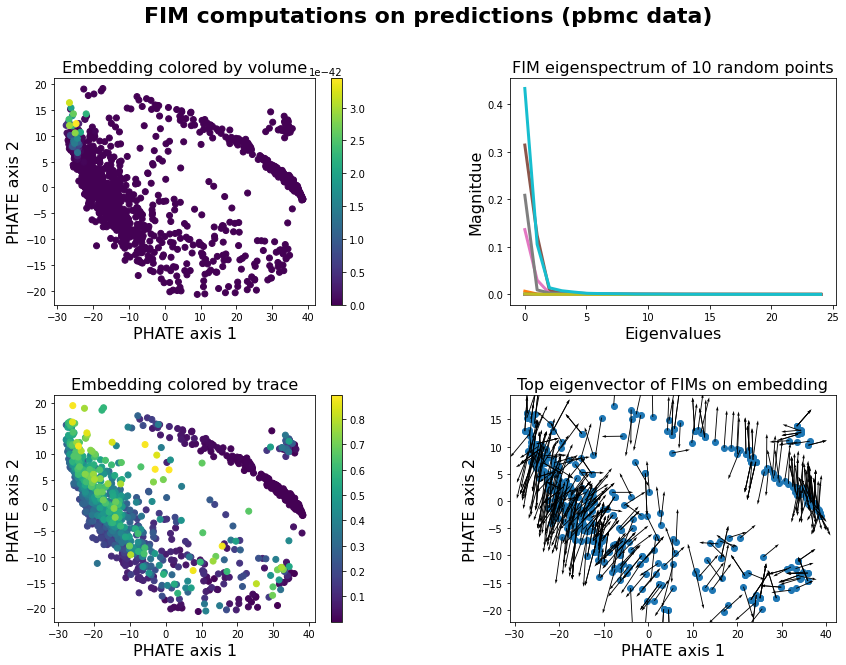

In [89]:
#Function for discarding outliers
per = 0.95 #CI to keep
def discard_out(metric,n_obs,per):
    
    ns_obs = per*n_obs
    out = int((n_obs - ns_obs)/2)
    sor = np.argsort(metric)
    lwindx = out
    upindx = n_obs - out
    sortind = sor[lwindx:upindx]
    return sortind


#Get Volume
#volume = volume/np.max(volume) #normalization
vind = discard_out(volume,n_obs,per)
nvolume = volume[vind]#/np.max(volume[vind])


#Compute quadratic form of first eigenvector
#quad = quad/np.max(quad)
#qind = discard_out(quad,n_obs,per)
#nquad = quad[qind]/np.max(quad[qind])


#Get Max eigenvalue
#emax = e[:,0]/np.max(trace) #normalized trace
#eind = discard_out(emax,n_obs,per)
#ne = emax[eind]/np.max(emax[eind])

#Get Trace
trace = np.zeros((n_obs))
for i in range(n_obs):
    trace[i] = np.sum(e[i,:])

#trace = trace/np.max(trace) #normalized trace
tind = discard_out(trace,n_obs,per)
ntrace = trace[tind]#/np.max(trace[tind])


plt.figure(figsize=(14,10))
plt.suptitle("FIM computations on predictions (pbmc data) ",fontsize=22,fontweight='bold')
plt.subplots_adjust(hspace=0.4,wspace=0.4)

#Trace
#plt.subplot(221)
#plt.title("Trace of FIM",fontsize=16)
#plt.plot(nvolume,linewidth=3)
#plt.xlabel("Data points",fontsize=16)
#plt.ylabel("Magnitude",fontsize=16)

#Volume
plt.subplot(221)
plt.title("Embedding colored by volume",fontsize=16)
plt.scatter(predemb[vind, 0], predemb[vind, 1], c= nvolume)
plt.xlabel("PHATE axis 1",fontsize=16)
plt.ylabel("PHATE axis 2",fontsize=16)
plt.colorbar()


#Eigenspectrum
rint = np.random.randint(0,len(testind),size=10)
plt.subplot(222)
plt.title("FIM eigenspectrum of 10 random points",fontsize=16)
for i in rint:
    plt.plot(e[i,:],linewidth=3)
    #plt.plot(e[eind[i],:]/np.max(e[eind[i],:]))
plt.xlabel("Eigenvalues",fontsize=16)
plt.ylabel("Magnitdue",fontsize=16)


#Trace
plt.subplot(223)
plt.title("Embedding colored by trace",fontsize=16)
plt.scatter(predemb[tind, 0], predemb[tind, 1], c= ntrace)
plt.xlabel("PHATE axis 1",fontsize=16)
plt.ylabel("PHATE axis 2",fontsize=16)
plt.colorbar()




#Visualization of eignevectors
reint = np.random.randint(0,pbmc_phate.shape[0],size=500) #Random 
plt.subplot(224)
plt.title("Top eigenvector of FIMs on embedding",fontsize=16)
plt.scatter(predemb[reint,0],predemb[reint,1])
plt.quiver(predemb[reint,0],predemb[reint,1],neivec[reint,0],neivec[reint,1],color = 'black',scale=30)
plt.xlabel("PHATE axis 1",fontsize=16)
plt.ylabel("PHATE axis 2",fontsize=16)

plt.savefig("Figures/pbmc_FIMcomps_1_21.png")

# IPSC Data

In [4]:
#load data
initdir = os.getcwd()
os.chdir(os.path.abspath('..') + '/src/data')
X = sio.loadmat('ipscData.mat')['data']
os.chdir(initdir)

In [91]:
print(X.shape)

(220450, 33)


In [5]:
#Get ipsc embedding
n_obs=1500
traind = random.sample(range(0,X.shape[0]),n_obs)
ipsc_data, ipsc_emb = make_ipsc(n_obs=n_obs,emb_dim=2,knn=5,indx=traind)




In [19]:
print(ipsc_data.shape)

torch.Size([1500, 33])


Text(0, 0.5, 'PHATE axis 2')

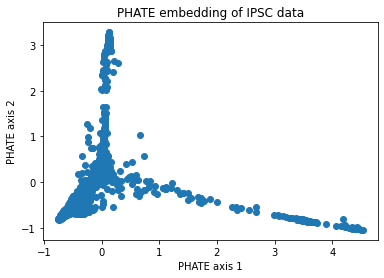

In [6]:
#IPSC data
plt.figure()
plt.title("PHATE embedding of IPSC data")
plt.scatter(ipsc_emb[:,0],ipsc_emb[:,1])
plt.xlabel("PHATE axis 1")
plt.ylabel("PHATE axis 2")

In [24]:
# Data Parameters
dataset = "ipsc"
n_obs = n_obs
n_dim = X.shape[1]
batch_size = 150

# Model param
encoder_layer = [100,100,50]
decoder_layer = [2,10,10]
emb_dim = encoder_layer[-1]
activation = "ReLU"
lr = 0.0001
kernel_type = "ipsc_phate"  # "gaussian" and "phate".
loss_emb = False  # Embedding loss.
loss_dist = True # distance loss in the embedding.
loss_rec = False
bandwitdh = 1  # bandwitdh for the gaussian kernel
t = 1  # time for the gaussian kernel. For PHATE, we use their optimal time.
scale = 0.00  # scale when we add noise to do the data (before the encoder).
knn = 5 # PHATE kernel number of Nearest Neighbors.
logp=True

# Trainer param
max_epochs = 150
fast_dev_run = False
accelerator = "gpu"
devices = 1

exp_name = "ipsc_autoencoder_logp"
seed = torch.randint(0, 1000, size=(1,))

In [9]:
# If you want to save and view in Wandb
wandb = False
logger = WandbLogger(project="ipsc_autoenocder_logp", name=exp_name) if wandb else False

In [18]:
PATH = os.getcwd()
train_loader = train_dataloader(dataset, n_obs, n_dim, emb_dim, batch_size,knn,PATH,indx=traind)

In [128]:
print(len(traind))

15000


In [25]:
# SEED
pl.utilities.seed.seed_everything(seed=seed)

# data loader for the training set.
#train_loader = train_dataloader(dataset, n_obs, n_dim, emb_dim, batch_size,knn,PATH)

# Defining the pytorch lightning model.
model_ipsc = LitAutoencoder(
    input_dim=n_dim,
    emb_dim=emb_dim,
    encoder_layer=encoder_layer,
    decoder_layer=decoder_layer,
    activation=activation,
    lr=lr,
    kernel_type=kernel_type,
    loss_emb=loss_emb,
    loss_dist=loss_dist,
    loss_rec=loss_rec,
    bandwitdh=bandwitdh,
    t=t,
    scale=scale,
    knn = knn,
    logp=logp
)

# Defining the trainer
# NOTE, we can add more things like gradient clipping, early stopping, Callbacks etc..
# NOTE logger is set to `FALSE`, change to `True` to keep tracks of the metrics.
# NOTE  `enable_checkpointing ` is set to `False`, set to `True` to keep checkpoints of the model.
trainer = Trainer(
    max_epochs=max_epochs,
    fast_dev_run=fast_dev_run,
    accelerator=accelerator,
    devices=devices,
    logger=logger,
    enable_checkpointing=False,
)


# Train the model
trainer.fit(model_ipsc, train_dataloaders=train_loader)

Global seed set to 364


[Linear(in_features=33, out_features=100, bias=True), ReLU(), Linear(in_features=100, out_features=100, bias=True), ReLU(), Linear(in_features=100, out_features=50, bias=True), Softmax(dim=1)]
[Linear(in_features=50, out_features=2, bias=True), ReLU(), Linear(in_features=2, out_features=10, bias=True), ReLU(), Linear(in_features=10, out_features=10, bias=True), ReLU()]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | encoder | Sequential | 18.6 K
1 | decoder | Sequential | 242   
---------------------------------------
18.8 K    Trainable params
0         Non-trainable params
18.8 K    Total params
0.075     Total estimated model params size (MB)
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:219: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 36 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=150` reached.


In [21]:
#save model (and load model)

torch.save(model_ipsc.state_dict(),'saved_models/ipsc_model_1_21.pt')
#model.load_state_dict(torch.load('saved_models/ipsc_model_1_18.pt'))

In [22]:
print(len(traind))

1500


In [26]:
n_obs=2000
nontrain = list( set(list(np.arange(X.shape[0]))) - set(traind))
testind = random.sample(nontrain,n_obs)
ipsc_data, ipsc_phate = make_ipsc(n_obs=n_obs,emb_dim=2,knn=5,indx=testind)



print(ipsc_data.shape)

ipsc_data = ipsc_data.to('cuda')
model_ipsc.cuda()
model_ipsc.eval()
pred = model_ipsc.encode(ipsc_data).detach().cpu().numpy()

print(pred.shape)

mds_operator = MDS()
predemb = mds_operator.fit_transform(pred)

print(predemb.shape)

torch.Size([2000, 33])
(2000, 50)
(2000, 2)


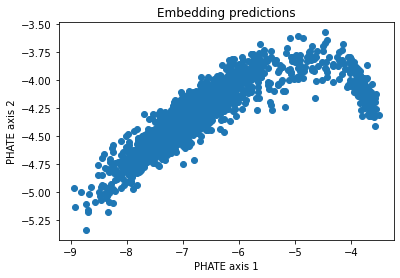

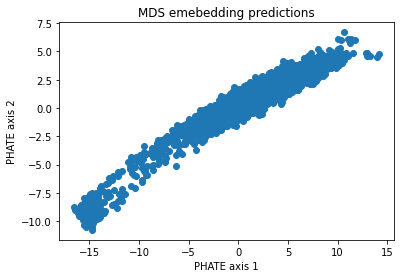

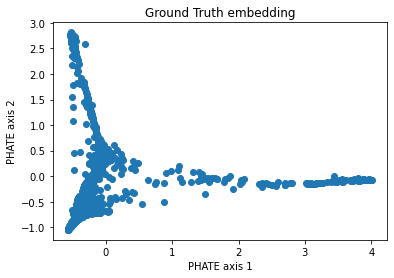

In [27]:

plt.figure()
plt.title("Embedding predictions")
plt.scatter(pred[:, 0], pred[:, 1])
plt.xlabel("PHATE axis 1")
plt.ylabel("PHATE axis 2")

plt.figure()
plt.title("MDS emebedding predictions")
plt.scatter(predemb[:, 0], predemb[:, 1])
plt.xlabel("PHATE axis 1")
plt.ylabel("PHATE axis 2")

plt.figure()
plt.title("Ground Truth embedding")
plt.scatter(ipsc_phate[:,0],ipsc_phate[:,1])
plt.xlabel("PHATE axis 1")
plt.ylabel("PHATE axis 2")



np.save("saved_data/1500_ipsc_1_21_1500_pred.npy",pred)
np.save("saved_data/1500_ipsc_1_21_1500_pred_MDS.npy",predemb)
np.save("saved_data/1500_ipsc_1_21_1500_ground_truth.npy",ipsc_phate)
plt.savefig("Figures/1500_ipsc_1_21_1500_ground_truth.png")

In [30]:

#Compute FIM 
model_ipsc.cuda()
fcn = model_ipsc.encode
fisher = FIM(ipsc_data,fcn,n_obs,n_dim,emb_dim,pred)
fishermat, J = fisher.fit()
e,v = fisher.get_eigs()

#quad = fisher.get_quadform(e[0,:])
#eone = np.zeros((v.shape[2])) #dimensionality of eigenvectors
#eone[0] = 1
#quad = fisher.get_quadform(eone)
volume = fisher.get_volume()

#Projecting eigenvectors to two dimensions for visualization
tvec = torch.unsqueeze(torch.tensor(v[:,:,0]).float().cuda(),0)
model_ipsc.eval()
vout = model_ipsc.encode(tvec).squeeze()
neivec = mds_operator.fit_transform(vout.detach().cpu().numpy())


KeyboardInterrupt: 

In [19]:
print(volume)

[0. 0. 0. ... 0. 0. 0.]


In [ ]:
#Function for discarding outliers
per = 0.95 #CI to keep
def discard_out(metric,n_obs,per):
    
    ns_obs = per*n_obs
    out = int((n_obs - ns_obs)/2)
    sor = np.argsort(metric)
    lwindx = out
    upindx = n_obs - out
    sortind = sor[lwindx:upindx]
    return sortind


#Get Volume
#volume = volume/np.max(volume) #normalization
vind = discard_out(volume,n_obs,per)
nvolume = volume[vind]#/np.max(volume[vind])


#Compute quadratic form of first eigenvector
#quad = quad/np.max(quad)
#qind = discard_out(quad,n_obs,per)
#nquad = quad[qind]/np.max(quad[qind])


#Get Max eigenvalue
#emax = e[:,0]/np.max(trace) #normalized trace
#eind = discard_out(emax,n_obs,per)
#ne = emax[eind]/np.max(emax[eind])


#Get Trace
trace = np.zeros((n_obs))
for i in range(n_obs):
    trace[i] = np.sum(e[i,:])

#trace = trace/np.max(trace) #normalized trace
tind = discard_out(trace,n_obs,per)
ntrace = trace[tind]#/np.max(trace[tind])


plt.figure(figsize=(14,10))
plt.suptitle("FIM computations on predictions (ipsc data) ",fontsize=22,fontweight='bold')
plt.subplots_adjust(hspace=0.4,wspace=0.4)

#Trace
#plt.subplot(221)
#plt.title("Trace of FIM",fontsize=16)
#plt.plot(nvolume,linewidth=3)
#plt.xlabel("Data points",fontsize=16)
#plt.ylabel("Magnitude",fontsize=16)

#Volume
plt.subplot(221)
plt.title("Embedding colored by volume",fontsize=16)
plt.scatter(predemb[vind, 0], predemb[vind, 1], c= nvolume)
plt.xlabel("PHATE axis 1",fontsize=16)
plt.ylabel("PHATE axis 2",fontsize=16)
plt.colorbar()


#Eigenspectrum
rint = np.random.randint(0,len(testind),size=10)
plt.subplot(222)
plt.title("FIM eigenspectrum of 10 random points",fontsize=16)
for i in rint:
    plt.plot(e[i,:],linewidth=3)
    #plt.plot(e[eind[i],:]/np.max(e[eind[i],:]))
plt.xlabel("Eigenvalues",fontsize=16)
plt.ylabel("Magnitdue",fontsize=16)


#Trace
plt.subplot(223)
plt.title("Embedding colored by trace",fontsize=16)
plt.scatter(predemb[tind, 0], predemb[tind, 1], c= ntrace)
plt.xlabel("PHATE axis 1",fontsize=16)
plt.ylabel("PHATE axis 2",fontsize=16)
plt.colorbar()



#Visualization of eignevectors
reint = np.random.randint(0,ipsc_phate.shape[0],size=1000) #Random 
plt.subplot(224)
plt.title("Top eigenvector of FIMs on embedding",fontsize=16)
plt.scatter(predemb[reint,0],predemb[reint,1])
plt.quiver(predemb[reint,0],predemb[reint,1],neivec[reint,0],neivec[reint,1],color = 'black',scale=15)
plt.xlabel("PHATE axis 1",fontsize=16)
plt.ylabel("PHATE axis 2",fontsize=16)

plt.savefig("Figures/ipsc_FIMcomps_1_18.png")